In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from scipy.linalg import eig
from TestProblems import CSTR_3state_model, CSTR_1state_model, PFR_1state_model, PFR_3state_model

In [10]:
# Common parameters
p = 1.0             # Density
cp = 4.186          # Specific heat capacity
k0 = np.exp(24.6)   # Arrhenius constant
Ea_R = 8500.0       # Activation energy   
deltaHr = -56000.0  # Reaction enthalphy
beta = -deltaHr / (p * cp)
V = 10.0            # Reactor volume
CAin = 5.0          # Inlet concentration A
CBin = 5.0          # Inlet concentration B
Tin = 300.0         # Inlet temperature (K)

# Flow rate range to analyze
F_range = np.linspace(0.4, 0.9, 20)  # From 200 to 800

# Function to compute steady states and eigenvalues for CSTR models
def analyze_cstr_model(model_func, params_base, state_size):
    steady_states = []
    eigenvalues = []
    
    for F in F_range:
        params = (F,) + params_base[1:]
        f, jac = model_func(params)
        
        # Find steady state by solving f(t, x) = 0
        def steady_state_eq(x):
            return f(0, x)
        
        # Initial guess (using inlet conditions)
        x0 = np.array([CAin, CBin, Tin]) if state_size == 3 else np.array([Tin])
        sol = fsolve(steady_state_eq, x0)
        steady_states.append(sol)
        
        # Compute Jacobian at steady state
        J = jac(0, sol)
        # Compute eigenvalues
        eigvals = eig(J)[0]
        eigenvalues.append(eigvals)
    
    return np.array(steady_states), eigenvalues

# Function to analyze PFR models (simplified - using discretization)
def analyze_pfr_model(model_func, params_base, state_size, n=10):
    steady_states = []
    eigenvalues = []
    dz = params_base['L']/n
    
    for F in F_range:
        v = F / params_base['A']
        p = params_base.copy()
        p['v'] = v
        
        u = (CAin, CBin, Tin)
        f, jac = model_func(u, p)
        
        # Initial state (spatial discretization)
        x0 = np.concatenate([np.full(n, CAin), np.full(n, CBin), np.full(n, Tin)]) if state_size == 3 else np.full(n, Tin)
        
        # Find steady state
        def steady_state_eq(x):
            return f(0, x)
        
        sol = fsolve(steady_state_eq, x0)
        steady_states.append(sol)
        
        # Compute Jacobian and eigenvalues
        J = jac(0, sol)
        eigvals = eig(J)[0]
        eigenvalues.append(eigvals)
    
    return np.array(steady_states), eigenvalues

# Analyze CSTR models
print("Analyzing CSTR 3-state model...")
cstr3_steady, cstr3_eig = analyze_cstr_model(CSTR_3state_model, (0, V, CAin, CBin, Tin), 3)

print("Analyzing CSTR 1-state model...")
#cstr1_steady, cstr1_eig = analyze_cstr_model(CSTR_1state_model, (0, V, CAin, CBin, Tin), 1)

# PFR parameters
pfr_params = {
    'L': 10,
    'A': 0.1,
    'D': [0.1, 0.1, 0.1],
    'beta': beta,
    'k': lambda T: k0 * np.exp(-Ea_R/T),
    'k0': k0,
    'dz': 0.1
}

print("Analyzing PFR 3-state model...")
pfr3_steady, pfr3_eig = analyze_pfr_model(PFR_3state_model, pfr_params, 3)

print("Analyzing PFR 1-state model...")
pfr1_steady, pfr1_eig = analyze_pfr_model(PFR_1state_model, pfr_params, 1)


# Plot results
print("Plotting steady state temperature vs flow rate...")
models = [
    (cstr3_steady, 3),
    (cstr1_steady, 1),
    (pfr3_steady, 3),
    (pfr1_steady, 1)
]
labels = ['CSTR 3-state', 'CSTR 1-state', 'PFR 3-state', 'PFR 1-state']
plot_steady_state_temperature(models, labels)

print("Plotting eigenvalue distributions...")
eigenvalues_list = [cstr3_eig, cstr1_eig, pfr3_eig, pfr1_eig]
plot_eigenvalues(eigenvalues_list, labels)

Analyzing CSTR 3-state model...
Analyzing CSTR 1-state model...
Analyzing PFR 3-state model...


/var/folders/v_/bb7dt9w12158g8xjfpl9dzfc0000gn/T/ipykernel_24832/815140797.py:31: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  sol = fsolve(steady_state_eq, x0)
/var/folders/v_/bb7dt9w12158g8xjfpl9dzfc0000gn/T/ipykernel_24832/815140797.py:31: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  sol = fsolve(steady_state_eq, x0)


ValueError: too many values to unpack (expected 3)

In [4]:
# Plotting functions
def plot_steady_state_temperature(models, labels):
    plt.figure(figsize=(10, 6))
    for i, (steady_states, state_size) in enumerate(models):
        if state_size == 3:
            # For 3-state models, temperature is the last element (for CSTR) or last third (for PFR)
            if len(steady_states[0]) > 100:  # PFR case
                n = len(steady_states[0]) // 3
                T_steady = [ss[2*n:3*n].mean() for ss in steady_states]  # Average temperature
            else:
                T_steady = [ss[-1] for ss in steady_states]
        else:
            # For 1-state models, it's just temperature
            if len(steady_states[0]) > 10:  # PFR case
                T_steady = [ss.mean() for ss in steady_states]  # Average temperature
            else:
                T_steady = [ss[0] for ss in steady_states]
        
        plt.plot(F_range, T_steady, label=labels[i])
    
    plt.xlabel('Flow rate (F)')
    plt.ylabel('Steady state temperature (K)')
    plt.title('Steady State Temperature vs Flow Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_eigenvalues(eigenvalues_list, labels):
    plt.figure(figsize=(12, 8))
    for i, eigenvalues in enumerate(eigenvalues_list):
        real_parts = []
        for eigvals in eigenvalues:
            real_parts.extend(np.real(eigvals))
        
        plt.hist(real_parts, bins=50, alpha=0.5, label=labels[i])
    
    plt.xlabel('Real part of eigenvalues')
    plt.ylabel('Frequency')
    plt.title('Distribution of Eigenvalues Real Parts')
    plt.legend()
    plt.grid(True)
    plt.show()

Plotting steady state temperature vs flow rate...


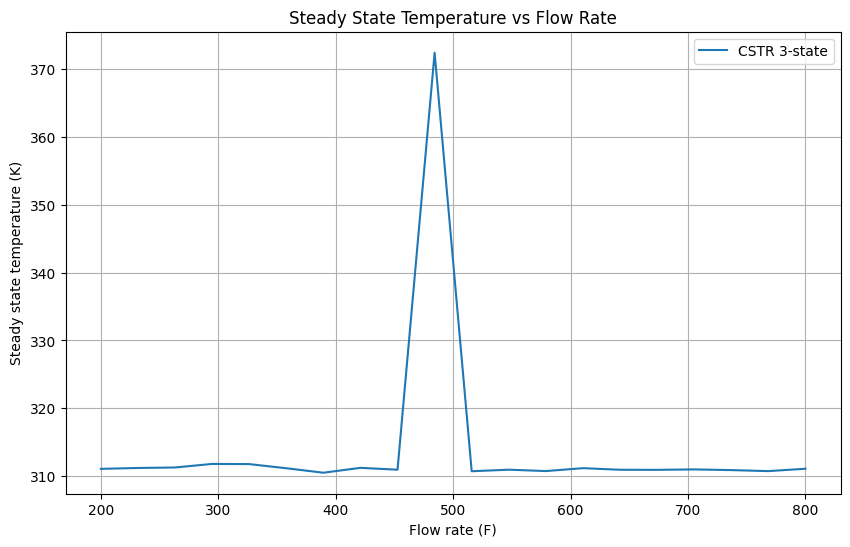

Plotting eigenvalue distributions...


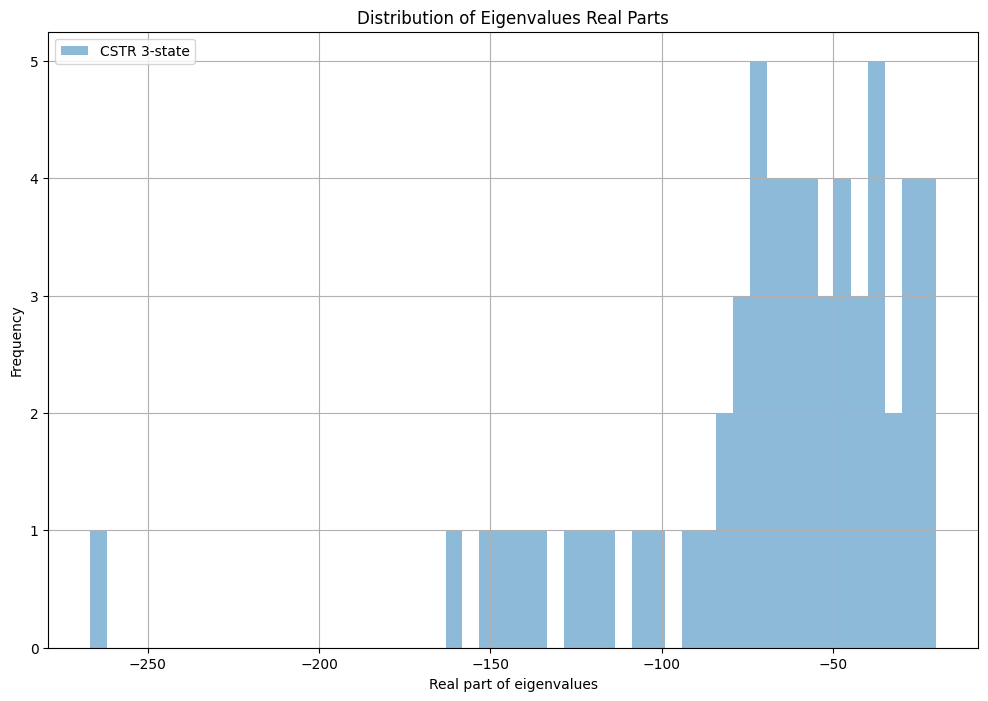

In [6]:
# Plot results
print("Plotting steady state temperature vs flow rate...")
models = [
    (cstr3_steady, 3)
]
labels = ['CSTR 3-state']
plot_steady_state_temperature(models, labels)

print("Plotting eigenvalue distributions...")
eigenvalues_list = [cstr3_eig]
plot_eigenvalues(eigenvalues_list, labels)